In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/SIH/data/raw_data"

'Ayrshire cattle'	    'Jaffrabadi Buffalo'  'Nili ravi Buffalo'
'Brown Swiss cattle'	    'Jersey cattle'	  'Rathi Cow'
'Gir Cow'		    'Kankrej Cow'	  'Sahiwal Cow'
'Hallikar Cow'		     Murrah		  'Tharparkar Cow'
'Holstein Friesian cattle'   Nagpuri


In [ ]:
import os, json, math, random, gc, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
# Enable mixed precision for better performance
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
IMG_SIZE = 224  # ResNet50 default
BATCH_SIZE = 16
VAL_SPLIT = 0.20       # 20% for val+test (we'll split this in half later into val and test)
SEED = 42
COLOR_MODE = "rgb"
EPOCHS_PHASE1 = 20
EPOCHS_PHASE2 = 15
BASE_LR = 0.0001
FINE_TUNE_LR = 0.00001
#LEARNING_RATE = 0.0001

In [ ]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/SIH/data/raw_data"

In [ ]:
# Solution 1: Clear cache files and restart
import os
import glob

# Clear all cache files
cache_files = glob.glob("/tmp/cattle_*.cache*")
lock_files = glob.glob("/tmp/cattle_*.lockfile")

print("Removing cache files...")
for file in cache_files + lock_files:
    try:
        os.remove(file)
        print(f"Removed: {file}")
    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error removing {file}: {e}")

print("Cache files cleared!")

Removing cache files...
Cache files cleared!


In [ ]:
if os.path.isdir(DATA_DIR):
  print(f"Folder found: {DATA_DIR}")
else:
  print(f"Folder not found: {DATA_DIR}")

Folder found: /content/drive/MyDrive/Colab Notebooks/SIH/data/raw_data


In [ ]:
def explore_dataset(data_dir):
    """
    Explore the dataset structure and show sample counts
    """
    print("Dataset Structure:")
    print("-" * 40)

    breeds = []
    image_counts = []

    if os.path.exists(data_dir):
        for breed_folder in sorted(os.listdir(data_dir)):
            breed_path = os.path.join(data_dir, breed_folder)
            if os.path.isdir(breed_path):
                image_count = len([f for f in os.listdir(breed_path)
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                breeds.append(breed_folder)
                image_counts.append(image_count)
                print(f"{breed_folder}: {image_count} images")

    total_images = sum(image_counts)
    print("-" * 40)
    print(f"Total Images: {total_images}")
    print(f"Total Breeds: {len(breeds)}")

    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.bar(breeds, image_counts, color=['skyblue' if 'cattle' in breed.lower() else 'lightcoral' for breed in breeds])
    plt.title('Distribution of Images per Breed')
    plt.xlabel('Breed')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return breeds, image_counts

Dataset Structure:
----------------------------------------
Ayrshire cattle: 260 images
Brown Swiss cattle: 238 images
Gir Cow: 250 images
Hallikar Cow: 210 images
Holstein Friesian cattle: 254 images
Jaffrabadi Buffalo: 210 images
Jersey cattle: 252 images
Kankrej Cow: 210 images
Murrah: 210 images
Nagpuri: 175 images
Nili ravi Buffalo: 210 images
Rathi Cow: 210 images
Sahiwal Cow: 240 images
Tharparkar Cow: 221 images
----------------------------------------
Total Images: 3150
Total Breeds: 14


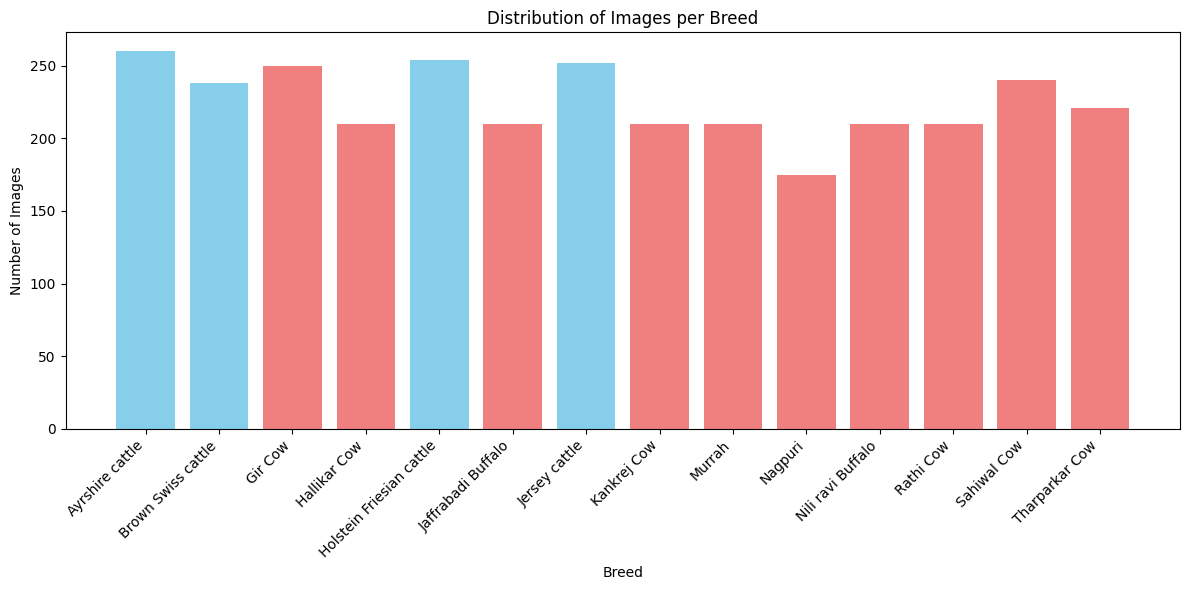

In [ ]:
# Explore your dataset
breeds, counts = explore_dataset(DATA_DIR)

In [ ]:
import os
for cls in sorted(os.listdir(DATA_DIR)):
    cls_path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(cls_path):
        print(cls, len(os.listdir(cls_path)))


Ayrshire cattle 260
Brown Swiss cattle 238
Gir Cow 250
Hallikar Cow 210
Holstein Friesian cattle 254
Jaffrabadi Buffalo 210
Jersey cattle 252
Kankrej Cow 210
Murrah 210
Nagpuri 180
Nili ravi Buffalo 210
Rathi Cow 210
Sahiwal Cow 240
Tharparkar Cow 221


In [ ]:
# Load datasets (train / val_temp)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",       # Automatically label based on folder
    label_mode="int",        # keep integer labels; we can one-hot later inside the model
    class_names=None,        # infer from subfolder names
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),     # will resize for you
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training",
)


Found 3155 files belonging to 14 classes.
Using 2524 files for training.


In [ ]:
val_temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation",
)

Found 3155 files belonging to 14 classes.
Using 631 files for validation.


In [ ]:
# Save class names (folder names) for later use
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Ayrshire cattle', 'Brown Swiss cattle', 'Gir Cow', 'Hallikar Cow', 'Holstein Friesian cattle', 'Jaffrabadi Buffalo', 'Jersey cattle', 'Kankrej Cow', 'Murrah', 'Nagpuri', 'Nili ravi Buffalo', 'Rathi Cow', 'Sahiwal Cow', 'Tharparkar Cow']


In [ ]:
# Check the labels
#print("Class labels:", train_ds.class_indices)
label_map = {i: name for i, name in enumerate(class_names)}
print(label_map)

{0: 'Ayrshire cattle', 1: 'Brown Swiss cattle', 2: 'Gir Cow', 3: 'Hallikar Cow', 4: 'Holstein Friesian cattle', 5: 'Jaffrabadi Buffalo', 6: 'Jersey cattle', 7: 'Kankrej Cow', 8: 'Murrah', 9: 'Nagpuri', 10: 'Nili ravi Buffalo', 11: 'Rathi Cow', 12: 'Sahiwal Cow', 13: 'Tharparkar Cow'}


In [ ]:
# Save mapping to file
label_map = {i: name for i, name in enumerate(class_names)}
#print(label_map)
with open("/content/drive/MyDrive/Colab Notebooks/SIH/data/class_names.json", "w") as f:
    json.dump(label_map, f, indent=2)
print("/content/drive/MyDrive/Colab Notebooks/SIH/data/class_names.json")

/content/drive/MyDrive/Colab Notebooks/SIH/data/class_names.json


In [ ]:
for images, labels in train_ds.take(1): # take first batch
  print("Labels: ",labels.numpy())
  print("Class names: ", [class_names[i] for i in labels.numpy()])

Labels:  [13 10  2  1  5 11  1  7 11 11  8 11  1  5  4  0]
Class names:  ['Tharparkar Cow', 'Nili ravi Buffalo', 'Gir Cow', 'Brown Swiss cattle', 'Jaffrabadi Buffalo', 'Rathi Cow', 'Brown Swiss cattle', 'Kankrej Cow', 'Rathi Cow', 'Rathi Cow', 'Murrah', 'Rathi Cow', 'Brown Swiss cattle', 'Jaffrabadi Buffalo', 'Holstein Friesian cattle', 'Ayrshire cattle']


In [ ]:
# revesre mapping
class_to_idx = {name: i for i, name in enumerate(class_names)}
print(class_to_idx)


{'Ayrshire cattle': 0, 'Brown Swiss cattle': 1, 'Gir Cow': 2, 'Hallikar Cow': 3, 'Holstein Friesian cattle': 4, 'Jaffrabadi Buffalo': 5, 'Jersey cattle': 6, 'Kankrej Cow': 7, 'Murrah': 8, 'Nagpuri': 9, 'Nili ravi Buffalo': 10, 'Rathi Cow': 11, 'Sahiwal Cow': 12, 'Tharparkar Cow': 13}


In [ ]:
# Split val_temp into real val and test (50/50)

In [ ]:
# In TensorFlow, a tf.data.Dataset doesn’t store everything in memory — it’s a pipeline of operations (like “read images → resize → batch → shuffle”)
# To know how many batches are inside the dataset, you use: tf.data.experimental.cardinality(dataset)
# This returns a special TensorFlow object (tf.Tensor) representing the count of batches
val_temp_batches = tf.data.experimental.cardinality(val_temp_ds).numpy()
print(val_temp_batches)

40


In [ ]:
test_ds = val_temp_ds.take(val_temp_batches // 2)
val_ds  = val_temp_ds.skip(val_temp_batches // 2)

In [ ]:
print("Batches -> train:", tf.data.experimental.cardinality(train_ds).numpy(),
      "| val:", tf.data.experimental.cardinality(val_ds).numpy(),
      "| test:", tf.data.experimental.cardinality(test_ds).numpy())

Batches -> train: 158 | val: 20 | test: 20


In [ ]:
print(32*(31+4+4))
print(260+238+254+252+204) # last batch are not full

1248
1208


Data augmentation (training only)

In [ ]:
#    Keep augmentations conservative to avoid distorting breed characteristics.
#    NOTE: These layers work fine before preprocess_input(i.e., before preprocess_input). Augmentation works on normal images (0–255 pixel range)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomZoom(height_factor=0.10, width_factor=0.10),
    tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
    tf.keras.layers.RandomBrightness(0.15),  # brightness variation
    tf.keras.layers.RandomContrast(0.15),    # contrast variation
    #tf.keras.layers.RandomCrop(height=200, width=200),  # Random crop then resize
    #tf.keras.layers.Resizing(224, 224)
], name="enhanced_data_augmentation")

Preprocess for ResNet50

In [ ]:
#    Use tf.keras.applications.resnet50.preprocess_input (Caffe-style: BGR, mean subtraction).
#    Do NOT also rescale 1/255.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def add_augmentation(image, label):
    # Apply only on training
    image = data_augmentation(image, training=True)
    return image, label

In [ ]:
def preprocess_for_resnet(image, label):
    image = tf.cast(image, tf.float32)      # convert to float32
    image = preprocess_input(image)  # expects float32 in [0..255]
    return image, label

In [ ]:
# Apply augmentation to train only, then preprocess on all sets
train_ds = (train_ds
            .map(add_augmentation, num_parallel_calls=AUTOTUNE)
            .map(preprocess_for_resnet, num_parallel_calls=AUTOTUNE))

In [ ]:
val_ds   = val_ds.map(preprocess_for_resnet, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(preprocess_for_resnet, num_parallel_calls=AUTOTUNE)

pipeline optimizations:- Caching, shuffling, prefetching (performance)
Cache to disk to avoid RAM spikes on large datasets in Colab.

In [ ]:
import time
import random

# Create unique cache names
cache_suffix = f"{int(time.time())}_{random.randint(1000, 9999)}"

train_ds = (train_ds
            .cache(f"/tmp/cattle_train_{cache_suffix}.cache")
            .shuffle(buffer_size= 200, seed=SEED, reshuffle_each_iteration=True)
            .prefetch(AUTOTUNE))

val_ds   = val_ds.cache(f"/tmp/cattle_val_{cache_suffix}.cache").prefetch(AUTOTUNE)
test_ds  = test_ds.cache(f"/tmp/cattle_test_{cache_suffix}.cache").prefetch(AUTOTUNE)

Quick sanity checks

In [ ]:
'''for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape, "Label batch shape:", labels.shape)
    print("Label dtype:", labels.dtype)
    print("Min/Max pixel after preprocess_input:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())'''

'for images, labels in train_ds.take(1):\n    print("Image batch shape:", images.shape, "Label batch shape:", labels.shape)\n    print("Label dtype:", labels.dtype)\n    print("Min/Max pixel after preprocess_input:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())'

Class distribution — helpful later for class weight

In [ ]:
'''import numpy as np

# Count labels in training dataset
train_class_counts = np.zeros(len(class_names))
for images, labels in train_ds.unbatch():
    train_class_counts[labels.numpy()] += 1

print("Class counts:", train_class_counts)'''

'import numpy as np\n\n# Count labels in training dataset\ntrain_class_counts = np.zeros(len(class_names))\nfor images, labels in train_ds.unbatch():\n    train_class_counts[labels.numpy()] += 1\n\nprint("Class counts:", train_class_counts)'

In [ ]:
def compute_balanced_class_weights():
    """Compute class weights using file count method (same as yours)"""
    class_counts = {}
    class_names_from_dir = sorted(os.listdir(DATA_DIR))

    for class_name in class_names_from_dir:
        class_path = os.path.join(DATA_DIR, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([f for f in os.listdir(class_path)
                                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Create labels array
    y_labels = []
    for i, class_name in enumerate(class_names_from_dir):
        if class_name in class_counts:
            y_labels.extend([i] * class_counts[class_name])

    # Compute balanced weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.arange(len(class_names_from_dir)),
        y=np.array(y_labels)
    )

    # Apply smoothing to prevent extreme weights (NEW IMPROVEMENT)
    class_weights = np.clip(class_weights, 0.5, 2.0)
    class_weights_dict = dict(enumerate(class_weights))

    print("Improved Class Weights:", class_weights_dict)
    return class_weights_dict
class_weights = compute_balanced_class_weights()

Improved Class Weights: {0: np.float64(0.8653846153846154), 1: np.float64(0.9453781512605042), 2: np.float64(0.9), 3: np.float64(1.0714285714285714), 4: np.float64(0.8858267716535433), 5: np.float64(1.0714285714285714), 6: np.float64(0.8928571428571429), 7: np.float64(1.0714285714285714), 8: np.float64(1.0714285714285714), 9: np.float64(1.2857142857142858), 10: np.float64(1.0714285714285714), 11: np.float64(1.0714285714285714), 12: np.float64(0.9375), 13: np.float64(1.0180995475113122)}


In [ ]:
num_classes = len(class_names)

In [ ]:
def create_breed_classification_model():
    """
    Create transfer learning model using ResNet50 as backbone
    ResNet50: 50-layer Residual Network pre-trained on ImageNet
    """

    # Load ResNet50 pre-trained on ImageNet (without top classification layer)
    base_model = ResNet50(
        weights='imagenet',  # Use ImageNet pre-trained weights
        include_top=False,   # Exclude final classification layer
        input_shape=(224, 224, 3),  # Input image shape
        pooling=None         # We'll add our own pooling
    )

    # Freeze the base model initially (transfer learning)
    base_model.trainable = False

    print(f"ResNet50 base model has {len(base_model.layers)} layers")
    print(f"Base model output shape: {base_model.output_shape}")

    # Build the complete model

    #Creates the "entrance door" for our images
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # Pass through ResNet50 base
    x = base_model(inputs, training=False)
    # Input: (IMG_SIZE, IMG_SIZE, 3) → ResNet50 → Output: (7, 7, 2048)

    # Add custom classification head with MORE regularization

    x = GlobalAveragePooling2D(name='global_avg_pooling')(x) # Converts the 3D feature map to a 1D vector; Before: (7, 7, 2048) = 100,352 numbers arranged in grids After: (2048,) = 2048 summary numbers
    x = BatchNormalization(name='batch_norm_1')(x) # Normalizes the data to have mean=0 and standard deviation=1
    x = Dropout(0.3, name='dropout_1')(x)
    # First dense layer with L2 regularization
    x = Dense(1024,
              activation='relu',
              kernel_regularizer=l2(0.005),  # NEW: L2 regularization
              name='dense_1')(x)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Dropout(0.5, name='dropout_2')(x)

    # Second dense layer with L2 regularization
    x = Dense(256,
              activation='relu',
              kernel_regularizer=l2(0.003),
              name='dense_2')(x)
    x = Dropout(0.2, name='dropout_3')(x)

    # Second dense layer
    x = Dense(256,
              activation='relu',
              kernel_regularizer=l2(0.005),
              name='dense_3')(x)
    x = Dropout(0.2, name='dropout_4')(x)

    # Final classification layer
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_regularizer=l2(0.001),
                    name='breed_classification',
                    dtype='float32')(x)

    # Create the model
    model = Model(inputs, outputs, name='Cattle_Buffalo_Breed_Classifier')

    return model, base_model


In [ ]:
# Create the model
print("Building ResNet50-based breed classification model...")
model, base_model = create_breed_classification_model()

Building ResNet50-based breed classification model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
ResNet50 base model has 175 layers
Base model output shape: (None, 7, 7, 2048)


In [ ]:
# Display model architecture
model.summary()

Model: "Cattle_Buffalo_Breed_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ breed_classification (Dense)    │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,029,966 (99.30 MB)

 Trainable params: 2,436,110 (9.29 MB)

 Non-trainable params: 23,593,856 (90.00 MB)

In [ ]:
# Visualize model architecture
#plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Create callbacks for better training
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1,
        mode='max',
        min_delta=0.003
    ),

    # Save best model
    ModelCheckpoint(
        '/content/drive/MyDrive/SIH/best_improved_model.keras', # use /content/drive/MyDrive/SIH/models/best_improved_model.keras
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
        mode='max'
    ),

    # Reduce learning rate when stuck
    # More aggressive learning rate reduction
    ReduceLROnPlateau(
        monitor='val_accuracy', # Monitor accuracy
        factor=0.3,             # Reduce by 70%
        patience=5,
        min_lr=1e-8,
        verbose=1,
        mode='max'
    )
]

In [ ]:
# Compile model with appropriate metrics

optimizer = Adam(learning_rate=BASE_LR)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

Model compiled successfully!


PHASE 1 TRAINING (FROZEN BASE MODEL)

In [ ]:
# Train with frozen base model
history_phase1 = model.fit(
    train_ds,
    epochs=EPOCHS_PHASE1,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights,
)

print("Phase 1 training completed!")

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1159 - loss: 12.3550
Epoch 1: val_accuracy improved from -inf to 0.51768, saving model to /content/drive/MyDrive/SIH/best_improved_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 1520s 6s/step - accuracy: 0.1161 - loss: 12.3533 - val_accuracy: 0.5177 - val_loss: 11.1161 - learning_rate: 1.0000e-04
Epoch 2/20
 22/158 ━━━━━━━━━━━━━━━━━━━━ 10:22 5s/step - accuracy: 0.2408 - loss: 11.5749

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Phase 1 - Test Accuracy: {test_acc:.4f}")
print(f"Phase 1 - Test Loss: {test_loss:.4f}")

PHASE 2 TRAINING (FINE-TUNING)

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Only unfreeze the last 15 layers (more conservative than your layer 100)
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfrozen layers: {len([layer for layer in base_model.layers if layer.trainable])}")

# VERY LOW learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LR * 0.5),  # Even lower LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks_phase2 = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,                 # Less patience for fine-tuning
            restore_best_weights=True,
            verbose=1,
            mode='max',
            min_delta=0.001
        ),

        ModelCheckpoint(
            '/content/drive/MyDrive/SIH/best_resnet50_finetuned.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        ),

        ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,                # Even more aggressive reduction
            patience=3,
            min_lr=1e-9,
            verbose=1,
            mode='max'
        )
    ]

In [ ]:

history_phase2 = model.fit(
    train_ds,
    epochs=EPOCHS_PHASE2,
    validation_data=val_ds,
    callbacks=callbacks_phase2,
    initial_epoch=len(history_phase1.history['loss']),
    verbose=1,   #initial_epoch=len(history_phase1.history['loss']),  # Continue from where Phase 1 ended also we need to increse epochs =
    class_weight=class_weights,
)

print("Fine-tuning completed!")

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

In [ ]:
# Check for overfitting
final_train_acc = history_phase2.history['accuracy'][-1]
final_val_acc = history_phase2.history['val_accuracy'][-1]
overfitting_gap = final_train_acc - final_val_acc

In [ ]:
print(f"\nOverfitting Analysis:")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Overfitting Gap: {overfitting_gap:.4f}")

if overfitting_gap > 0.15:
    print("⚠️  Still overfitting - consider more regularization")
elif overfitting_gap > 0.10:
    print("⚠️  Mild overfitting - acceptable")
else:
    print("✅ Good generalization!")

In [ ]:
# Add this after training to analyze performance
def analyze_model_performance(model, test_ds, class_names):
    """Analyze model performance in detail"""

    # Get predictions and true labels
    y_pred = []
    y_true = []

    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())

    # Classification report
    from sklearn.metrics import classification_report, confusion_matrix

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Run analysis
analyze_model_performance(model, test_ds, class_names)

In [ ]:
'''# Train 3-5 models with different random seeds
ensemble_models = []
for seed in [42, 123, 456, 789, 999]:
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Create and train model
    model_i, _ = create_breed_classification_model()
    # ... train model_i ...
    ensemble_models.append(model_i)

# Ensemble prediction
def ensemble_predict(models, img_path):
    predictions = []
    for model in models:
        # ... preprocess image ...
        pred = model.predict(img_array)
        predictions.append(pred)

    # Average predictions
    avg_pred = np.mean(predictions, axis=0)
    return avg_pred'''

In [ ]:

def predict_cattle_breed(model, img_path, class_names):
    """Predict cattle breed using tf.data approach"""

    # Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array = tf.cast(img_array, tf.float32)
    img_array = preprocess_input(img_array)      # Use ResNet50 preprocessing

    # Make prediction
    predictions = model.predict(img_array)     # ex [[0.85, 0.08, 0.04, 0.02, 0.01]] 2D array
    predicted_class_idx = np.argmax(predictions[0])  #Finds the position of the highest probability ex: 0
    confidence = np.max(predictions[0])           #Gets the actual highest probability value ex: 0.85

    # Get breed name
    predicted_breed = class_names[predicted_class_idx]

    # Show results
    print(f"\nPrediction for {img_path}:")
    print(f"Predicted breed: {predicted_breed}")
    print(f"Confidence: {confidence:.2%}")
    print("\nAll breed probabilities:")
    for i, prob in enumerate(predictions[0]):
        print(f"  {class_names[i]}: {prob:.2%}")

    return predicted_breed, confidence

# Example usage
'''breed, confidence = predict_cattle_breed(
    model,
    'path/to/cattle_image.jpg',
    train_ds.class_names  # Use this instead of class_indices
)'''